In [88]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats
import os

In [89]:
# Load datasets
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02CRI.nc")
# catalog = pd.read_csv('eq_200204_202102.csv')
# catalog["time"] = catalog["time"].astype("datetime64")
catalog = pd.read_csv(dataset_path + 'ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

In [90]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data
  
catalog['dmass'] = catalog.apply(lambda row: get_mass(row), axis=1)

In [40]:
# catalog['on_land'] = globe.is_land(catalog.latitude, catalog.longitude)

In [301]:
def plot_hist(all_time_periods, earthquake_only, ax1, ax2, title1, title2):
    
    # Cumulative histogram

    bins = np.linspace(-80,80,41)
    ax1.hist(earthquake_only, bins, density = True, cumulative=True, histtype='step',
            label='Time periods with an earthquake',linewidth=1.5)
    ax1.hist(all_time_periods, bins, density = True, cumulative=True,histtype='step',
            label='All time periods',linewidth=1.5)
    ax1.set_ylim((-0.1,1.3))
    ax1.legend()
    ax1.set_xlabel('Surface load (cm water equiv.)', fontsize = 17)
    ax1.set_ylabel("Cumulative probability", fontsize = 17)
    ax1.set_title(title1)
    
    # Non-cumulative histogram

    ax2.hist(earthquake_only, bins, density = True, cumulative=False, histtype='step',
            label='Time periods with an earthquake',linewidth=1.5)
    ax2.hist(all_time_periods, bins, density = True, cumulative=False,histtype='step',
            label='All time periods',linewidth=1.5)
    yl = ax2.get_ylim()
    ax2.set_ylim((-0.01,1.4*yl[1]))
    ax2.set_xlim((-40,60))
    ax2.legend()
    ax2.set_xlabel('Surface load (cm water equiv.)', fontsize = 17)
    ax2.set_ylabel("Probability", fontsize = 17)
    ax2.set_title(title2)

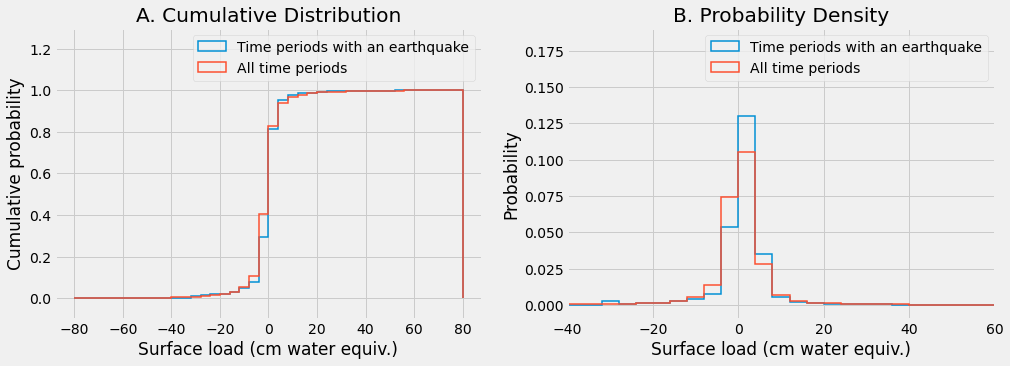

In [302]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('fivethirtyeight')

plot_hist(np.array(ds['lwe_thickness'].data.flatten()), np.array(catalog.dmass), ax1, ax2, 
              'A. Cumulative Distribution', 'B. Probability Density')

In [95]:
def calc_stats(a,b):
    '''
    Calculate stats for the distributions a and b
    a: distribution during earthquakes
    b: distribution over all time periods
    '''
    
    result = {} # this creates a dictionary
    
    result['cvm'] = stats.cramervonmises_2samp(a, b, method='auto')
    result['ks'] = stats.ks_2samp(a, b)
    result['median_all'] = np.median(b)
    result['median_eq'] = np.median(a)
    result['mean_all'] = np.mean(b)
    result['mean_eq'] = np.mean(a)
    result['mean_all_minus_mean_eq'] = np.mean(b)-np.mean(a)
    result['median_all_minus_median_eq'] = np.median(b)-np.median(a)
    
    return result

## Using Bayes' Theorem:

In [305]:
# Relative probability of earthquake given loading

def plot_rel_hist(all_time_periods, earthquake_only, ax, title):
    
    bins = np.linspace(-80,80,41)
    LgE = np.histogram(earthquake_only, bins=bins, density = True)[0]
    L   = np.histogram(all_time_periods,bins=bins, density = True)[0]

    wid = np.mean(np.diff(bins))
    ax.bar(bins[:-1]+wid/2,LgE/L,width=wid)

    ax.plot([-80,80],[1, 1],'--r')
    ax.text(-20, 1.5,'P=P(E)',color='r',fontsize=20)
    ax.set_xlabel('Surface Load (cm water equiv.)',fontsize = 17)
    ax.set_ylabel('Relative Probability',fontsize = 17)
    ax.set_title(title, fontsize = 17)
    return fig,ax


(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Relative Probability Of Earthquake'}, xlabel='Surface Load (cm water equiv.)', ylabel='Relative Probability'>)

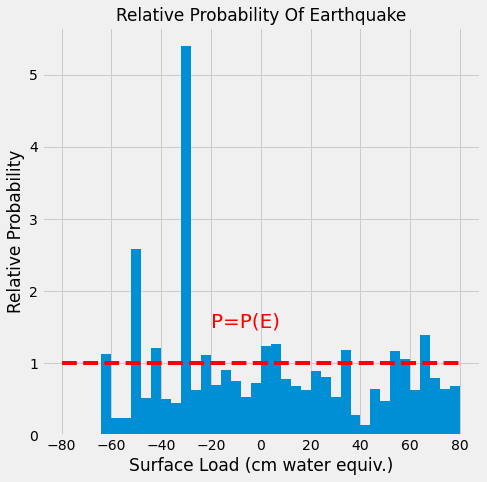

In [306]:
fig,ax = plt.subplots(figsize=(7,7))
plt.style.use('fivethirtyeight')
plot_rel_hist(np.array(ds['lwe_thickness'].data.flatten()), np.array(catalog.dmass), ax, 
              "Relative Probability Of Earthquake")

In [96]:
calc_stats(np.array(catalog.dmass),np.array(ds['lwe_thickness'].data.flatten()))

{'cvm': CramerVonMisesResult(statistic=60.854618746814594, pvalue=9.69405278272717e-09),
 'ks': KstestResult(statistic=0.12212035878155786, pvalue=2.4886704147936648e-123),
 'median_all': 0.6627782418257632,
 'median_eq': 1.425528633547053,
 'mean_all': -0.5782975724802435,
 'mean_eq': 1.1185184026716928,
 'mean_all_minus_mean_eq': -1.6968159751519363,
 'median_all_minus_median_eq': -0.7627503917212898}

## Correlation between reconstructed D values and seismic activity


In [ ]:
# Loading D values from pca grace

D_eq_values = []
for filenumber in np.arange(1,7):
    filename = os.path.join('/data/fast1/surface-load/pca/','D_eq_%d.csv'%filenumber)
    D_eq_values.append( np.loadtxt(filename, delimiter=',') )
    # asumes filenames like 'D_eq_values_1.csv', 'D_eq_values_2.csv', and so on

D_values = []
for filenumber in np.arange(1,7):
    filename = os.path.join('/data/fast1/surface-load/pca/','D_%d.csv'%filenumber)
    D_values.append( np.loadtxt(filename, delimiter=',') )

In [ ]:
stats = []

for i in range(6):
    stats.append(calc_stats(D_eq_values[i], D_values[i]))

pd.DataFrame(stats)


## Correlation between detrended D values and seismic activity

In [ ]:
# Loading detrended data

D_detrend_eq_values = []
for filenumber in np.arange(1,7):
    D_detrend_eq_values.append( np.loadtxt('D_detrend_eq_%d.csv'%filenumber, delimiter=',') )

D_detrend_values = []
for filenumber in np.arange(1,7):
    D_detrend_values.append( np.loadtxt('D_detrend_%d.csv'%filenumber, delimiter=',') )

In [ ]:
stats_detrend = []

for i in range(6):
    stats_detrend.append(calc_stats(D_detrend_eq_values[i], D_detrend_values[i]))

In [ ]:
stats_detrend

## Maps 

In [ ]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(catalog.longitude, catalog.latitude))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(color='white', edgecolor='black', figsize=(8,6))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax, label='Distribution of earthquakes in catalog')
leg = ax.legend()

# gdi = gpd.GeoDataFrame(df_ind, geometry=gpd.points_from_xy(df_ind.longitude, df_ind.latitude))
# gdi.plot(ax=ax, markersize = 5)

# plt.show()

In [ ]:
# function to plot maps of earthquake distribution

def plot_map(thr, earthquake_only):
    
    df_bigmass = catalog[np.abs(earthquake_only) > thr]
    gdf = gpd.GeoDataFrame(df_bigmass,
                           geometry=gpd.points_from_xy(df_bigmass.longitude, 
                                                   df_bigmass.latitude))

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
    gdf.plot(ax=ax, label='All earthquakes that occured at surface load > 25')
    leg = ax.legend()
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    plt.show()

In [ ]:
plot_map(25, catalog['dmass'])

### Maps for not detrended analyses

In [ ]:
for i in range(6):
    plot_map(25, D_eq_values[i])

### Maps for detrended analyses

In [ ]:
for i in range(6):
    plot_map(25, D_detrend_eq_values[i])

### Plotting all PCs on the same map

In [269]:
def plot_same_map(eq_first_pc, eq_second_pc, bigmass1, bigmass2, label1, label2):

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))

    # first PC
    df_bigmass = bigmass1
    gdf = gpd.GeoDataFrame(df_bigmass,
                       geometry=gpd.points_from_xy(df_bigmass.longitude, df_bigmass.latitude))
    gdf.plot(ax=ax, label=label1)


    # second pc
    df_bigmass = bigmass2
    gdf = gpd.GeoDataFrame(df_bigmass,
                       geometry=gpd.points_from_xy(df_bigmass.longitude, df_bigmass.latitude))
    gdf.plot(ax=ax, label=label2)


    leg = ax.legend()
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    plt.show()

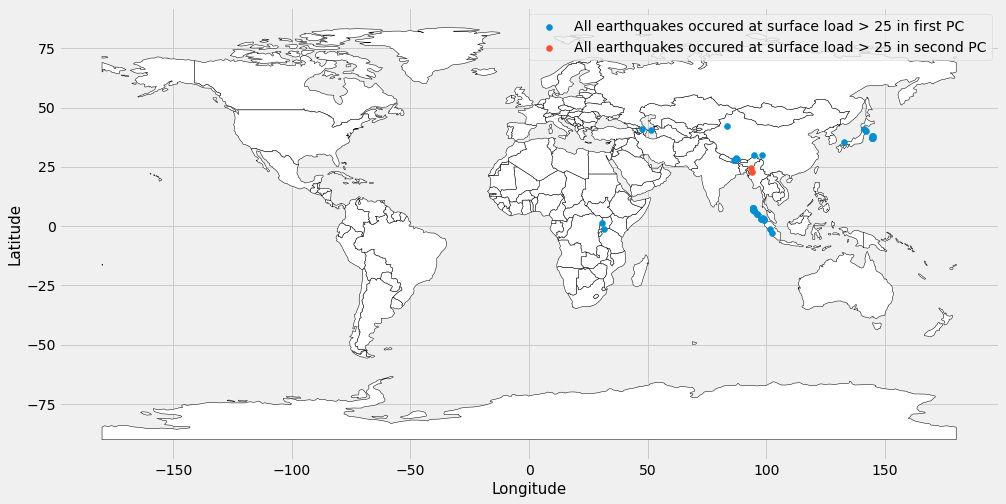

In [205]:
plot_same_map(D_eq_values[0],D_eq_values[1], 
              catalog[np.abs(D_eq_values[0]) > 25],
              catalog[np.abs(D_eq_values[1]) > 25], 
              'All earthquakes occured at surface load > 25 in first PC',
              'All earthquakes occured at surface load > 25 in second PC')

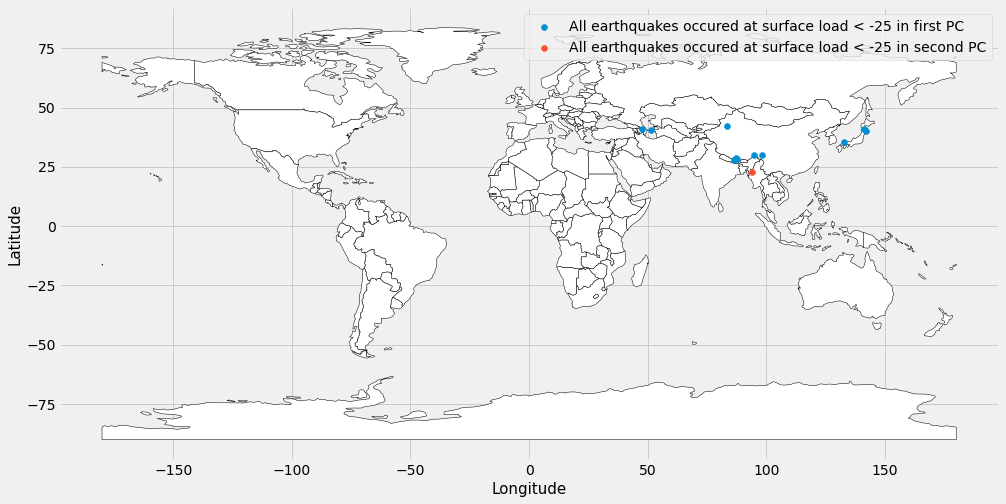

In [203]:
plot_same_map(D_eq_values[0],D_eq_values[1],
               catalog[D_eq_values[0] < -25],
               catalog[D_eq_values[1] < -25],
               'All earthquakes occured at surface load < -25 in first PC',
               'All earthquakes occured at surface load < -25 in second PC')

### Plotting all pcs on the same map for detrended data

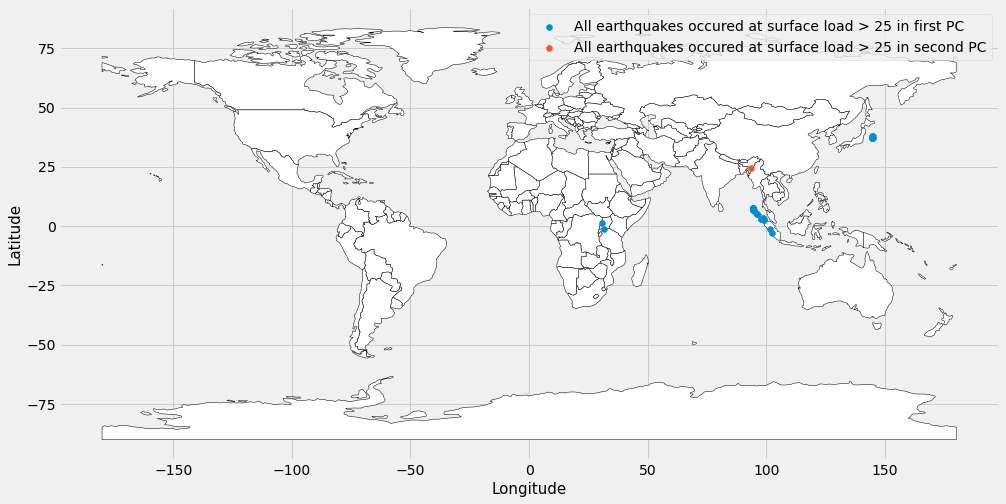

In [207]:
plot_same_map(D_detrend_eq_values[0],D_detrend_eq_values[1],
               catalog[D_detrend_eq_values[0] > 25],
               catalog[D_detrend_eq_values[1] > 25],
              'All earthquakes occured at surface load > 25 in first PC',
              'All earthquakes occured at surface load > 25 in second PC')

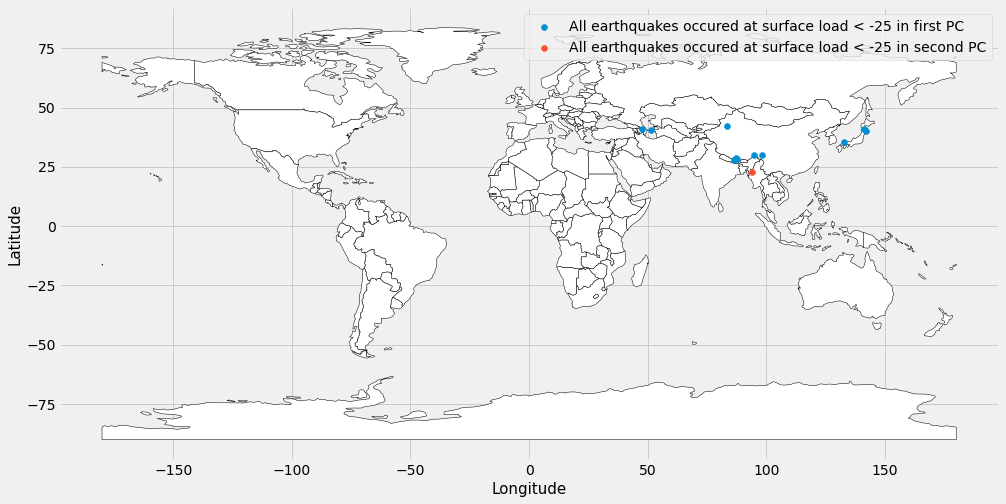

In [206]:
plot_same_map(D_detrend_eq_values[0],D_detrend_eq_values[1],
               catalog[D_detrend_eq_values[0] < -25],
               catalog[D_detrend_eq_values[1] < -25],
               'All earthquakes occured at surface load < -25 in first PC',
               'All earthquakes occured at surface load < -25 in second PC')

## Map of earthquakes with relative probability > 2

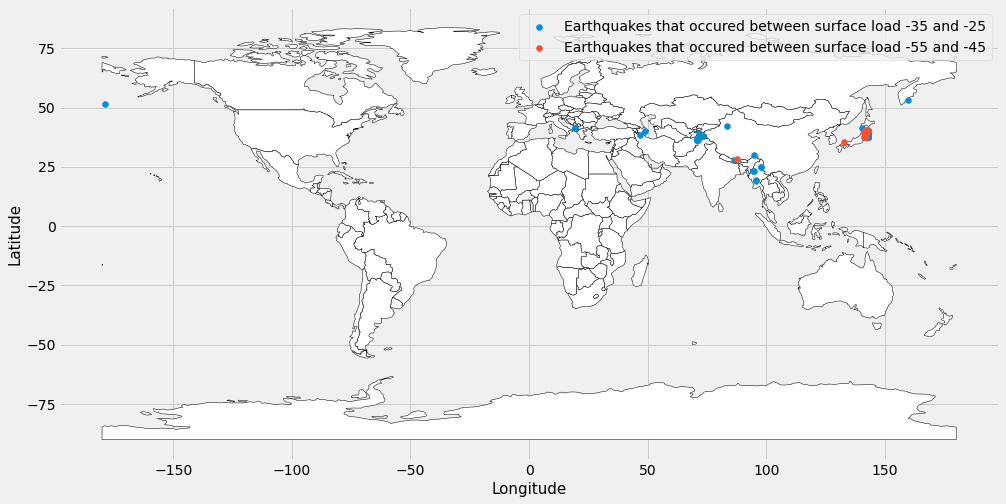

In [307]:
plot_same_map(catalog['dmass'],catalog['dmass'],
             catalog[(-35 < catalog['dmass']) & (catalog['dmass'] < -25)],
             catalog[(-55 < catalog['dmass']) & (catalog['dmass'] < -45)],
             'Earthquakes that occured between surface load -35 and -25',
             'Earthquakes that occured between surface load -55 and -45')

## Figures for poster

In [180]:
def set_of_figures(all_time, earthquake_only):

    fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,5))

    plt.style.use('fivethirtyeight')
    plot_hist(all_time, earthquake_only, ax1, ax2, 
              'A. Cumulative Distribution', 'B. Probability Density')

    plot_rel_hist(all_time, earthquake_only, ax3, 
                  'C. Relative probability of earthquake')

    fig.tight_layout()

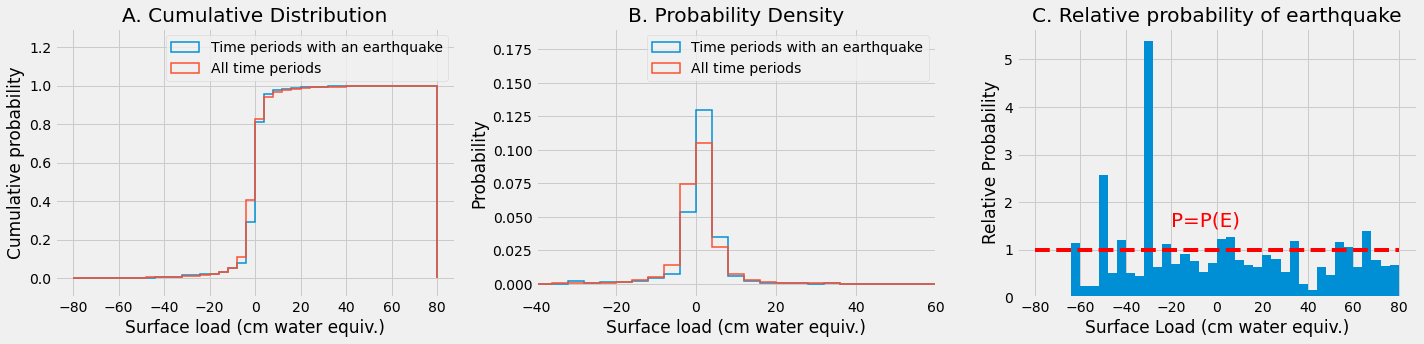

In [276]:
# Main result

set_of_figures(ds['lwe_thickness'].data.flatten(),catalog['dmass'])

<ipython-input-282-ce78173e416c>:10: RuntimeWarning: invalid value encountered in true_divide
  ax.bar(bins[:-1]+wid/2,LgE/L,width=wid)


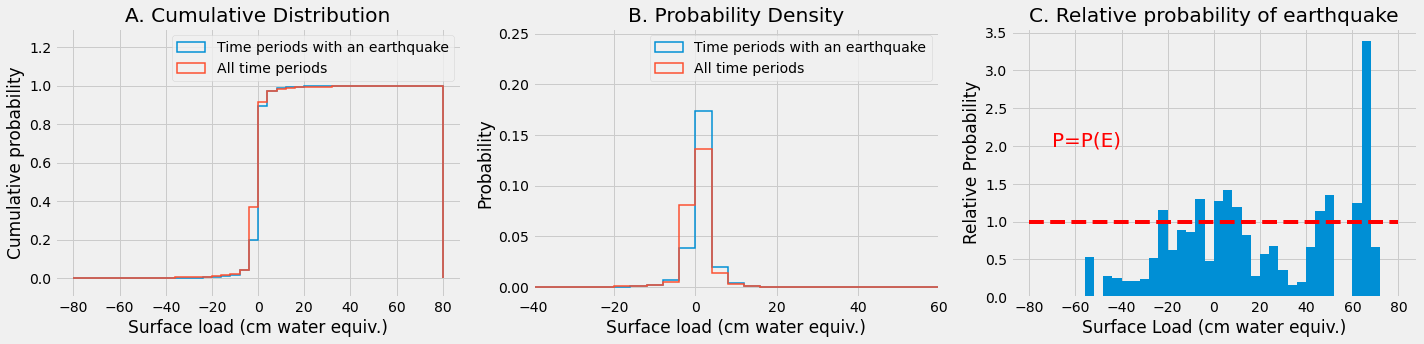

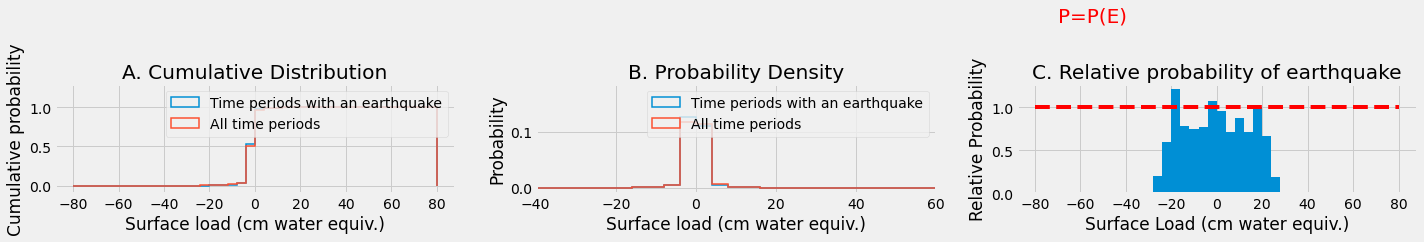

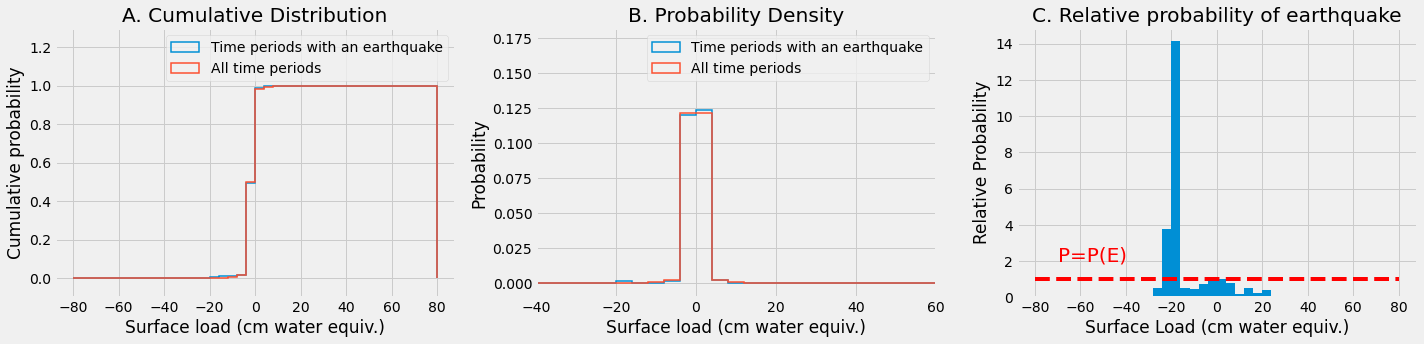

In [284]:
# Correlation using PCs

for i in range(3):
    set_of_figures(D_values[i].flatten(), D_eq_values[i])

<ipython-input-282-ce78173e416c>:10: RuntimeWarning: invalid value encountered in true_divide
  ax.bar(bins[:-1]+wid/2,LgE/L,width=wid)


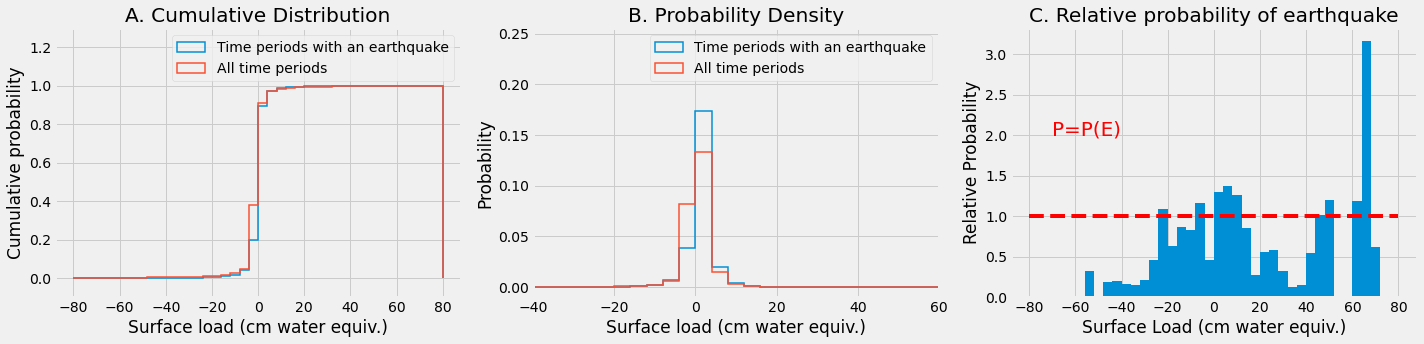

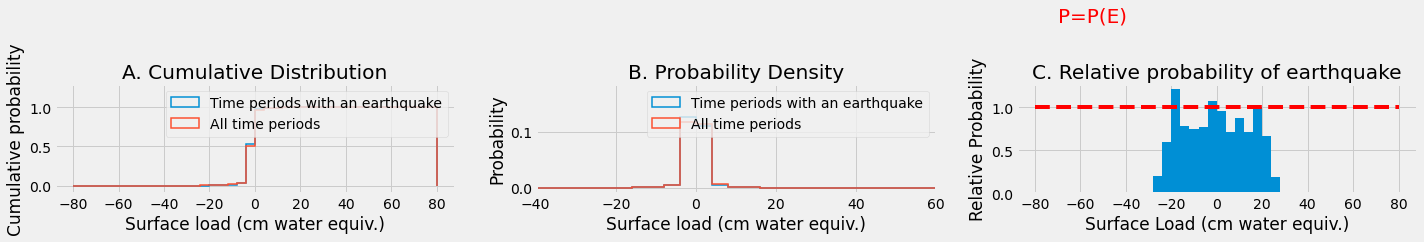

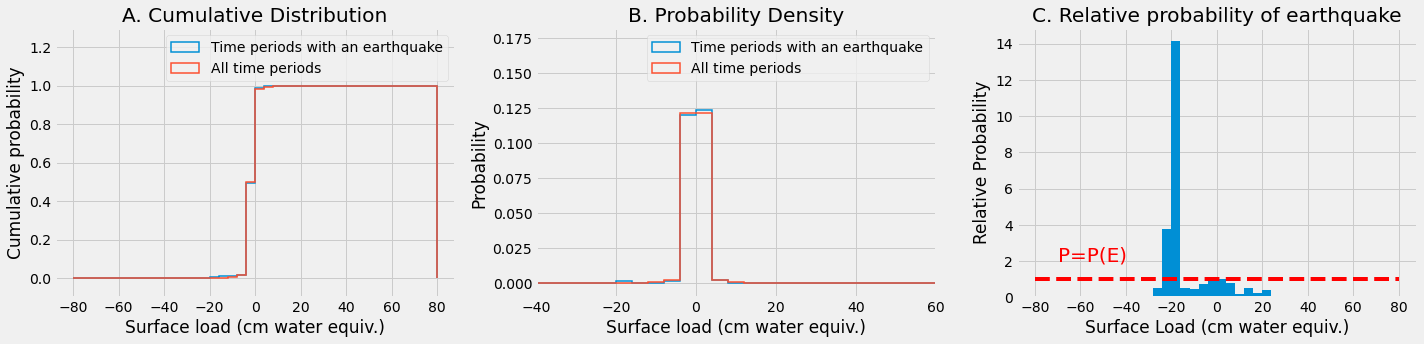

In [283]:
# Detrended PCs

for i in range(3):
    set_of_figures(D_detrend_values[i].flatten(), D_detrend_eq_values[i])